In [30]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

intp = 1  #tomar uno de cada cien valores, para graficar rapido


BSIZE_SP = 512 # Max size of a line of data; we don't want to read the
               # whole file to find a line, in case file does not have
               # expected structure.

MDATA_LIST = [b'title', b'date', b'plotname', b'flags', b'no. variables',
              b'no. points', b'dimensions', b'command', b'option']

def rawread(fname: str):
    """Read ngspice binary raw files. Return tuple of the data, and the
    plot metadata. The dtype of the data contains field names. This is
    not very robust yet, and only supports ngspice.
    
    >>> darr, mdata = rawread('test.py')
    >>> darr.dtype.names
    >>> plot(np.real(darr['frequency']), np.abs(darr['v(out)']))
    """
    # Example header of raw file
    # Title: rc band pass example circuit
    # Date: Sun Feb 21 11:29:14  2016
    # Plotname: AC Analysis
    # Flags: complex
    # No. Variables: 3
    # No. Points: 41
    # Variables:
    #         0       frequency       frequency       grid=3
    #         1       v(out)  voltage
    #         2       v(in)   voltage
    # Binary:
    fp = open(fname, 'rb')
    arrs = []
    plots = []
    plot = {}
    while (True):
        try:
            # mdata = fp.readline(BSIZE_SP).split(b':', maxsplit=1)
            mdata = fp.readline().split(b':', maxsplit=1)
        except:
            raise
        if len(mdata) == 2:
            if mdata[0].lower() in MDATA_LIST:
                plot[mdata[0].lower()] = mdata[1].strip()
            if mdata[0].lower() == b'variables':
                nvars = int(plot[b'no. variables'])
                npoints = int(plot[b'no. points'])
                plot['varnames'] = []
                plot['varunits'] = []
                for varn in range(nvars):
                    # varspec = (fp.readline(BSIZE_SP).strip().decode('ascii').split())
                    varspec = (fp.readline().strip().decode('ascii').split())
                    assert(varn == int(varspec[0]))
                    plot['varnames'].append(varspec[1])
                    plot['varunits'].append(varspec[2])
            if mdata[0].lower() == b'binary':
                rowdtype = np.dtype({'names': plot['varnames'],
                                     'formats': [np.complex_ if b'complex'
                                                 in plot[b'flags']
                                                 else np.float_]*nvars})
                # We should have all the metadata by now
                arrs.append(np.fromfile(fp, dtype=rowdtype, count=npoints))
                plots.append(plot)
                plot = {} # reset the plot dict
                fp.readline() # Read to the end of line
        else:
            break
    return (arrs[0], plots)


    

In [31]:
data, plots = rawread("tb_pendulum.raw")


In [32]:
plots

[{b'title': b'** sch_path: /home/alex/desktop/eda/snn_ipn/tb_pendulum.sch',
  b'date': b'Wed Jan 22 16:40:24  2025',
  b'plotname': b'Transient Analysis',
  b'flags': b'real',
  b'no. variables': b'72',
  b'no. points': b'221834',
  'varnames': ['time',
   'v(j1)',
   'v(j2)',
   'v(j3)',
   'v(j4)',
   'v(j5)',
   'v(j6)',
   'v(j7)',
   'v(j8)',
   'v(k1)',
   'v(k2)',
   'i(v.x1.x1.vext)',
   'i(v.x1.x2.vext)',
   'i(v.x1.x3.vext)',
   'i(v.x1.x4.vext)',
   'i(v.x1.x5.vext)',
   'i(v.x1.x6.vext)',
   'i(v.x1.x7.vext)',
   'i(v.x1.x8.vext)',
   'i(v.x2.x1.vext)',
   'i(v.x2.x2.vext)',
   'i(v.x3.xrstdp1.vmr)',
   'i(v.x3.xrstdp2.vmr)',
   'i(v.x3.xrstdp5.vmr)',
   'i(v.x3.xrstdp6.vmr)',
   'i(v.x3.xrstdp9.vmr)',
   'i(v.x3.xrstdp10.vmr)',
   'i(v.x3.xrstdp13.vmr)',
   'i(v.x3.xrstdp14.vmr)',
   'i(v.x3.xrstdp17.vmr)',
   'i(v.x3.xrstdp18.vmr)',
   'i(v.x3.xrstdp21.vmr)',
   'i(v.x3.xrstdp22.vmr)',
   'i(v.x3.xrstdp25.vmr)',
   'i(v.x3.xrstdp26.vmr)',
   'i(v.x3.xrstdp29.vmr)',
   'i(

Text(0.5, 1.0, 'Input Current First Layer')

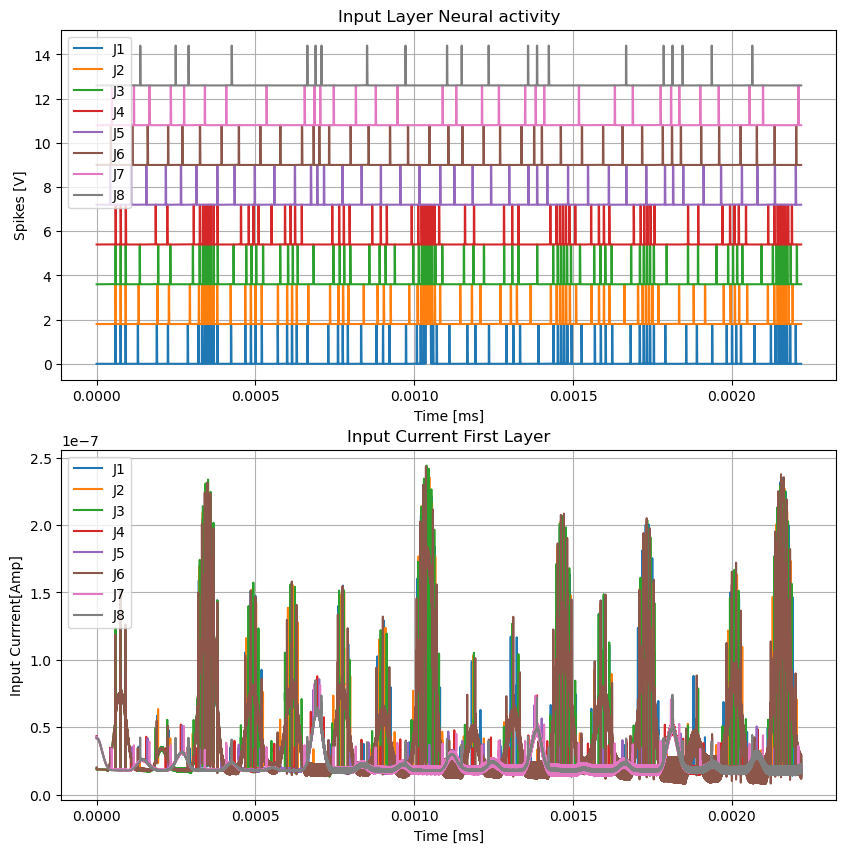

In [33]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
for k in range(8):
    nodo = "v(j" +  str(k+1) + ")"
    ax1.plot(data["time"][::intp], data[nodo][::intp]+(1.8*k), label = f"J{k+1}")

ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Spikes [V]")
ax1.set_title("Input Layer Neural activity")


for k in range(8):
    Iext_label = "i(v.x1.x" + str(k+1)+ ".vext)"
    ax2.plot(data["time"][::intp], data[Iext_label][::intp], label = f"J{k+1}")

ax2.grid()
ax2.legend()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Currrent[Amp]")
ax2.set_title("Input Current First Layer")
# ax.set_ylim((-0, 3e-6))

# fig.savefig('InputLayer.pdf')

Text(0.5, 1.0, 'Input Current Output Layer')

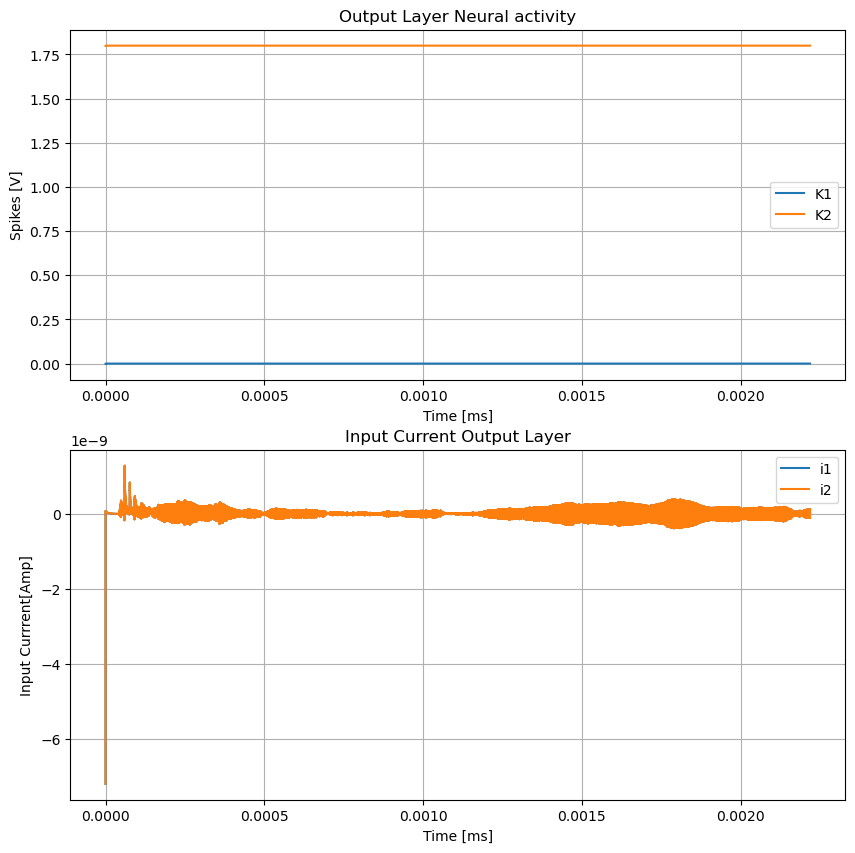

In [34]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
for k in range(2):
    nodo = "v(k" +  str(k+1) + ")"
    ax1.plot(data["time"][::intp], data[nodo][::intp]+(1.8*k), label = f"K{k+1}")

ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Spikes [V]")
ax1.set_title("Output Layer Neural activity")


for k in range(2):
    Iext_label = "i(v.x2.x" + str(k+1)+ ".vext)"
    ax2.plot(data["time"][::intp], data[Iext_label][::intp], label = f"i{k+1}")

ax2.grid()
ax2.legend()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Currrent[Amp]")
ax2.set_title("Input Current Output Layer")
# ax.set_ylim((-0, 3e-6))

# fig.savefig('InputLayer.pdf')